# 6. 합성곱 신경망
## 6.3 ResNet

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd/content/gdrive/My Drive/pytorch_dlbro

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True) 

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


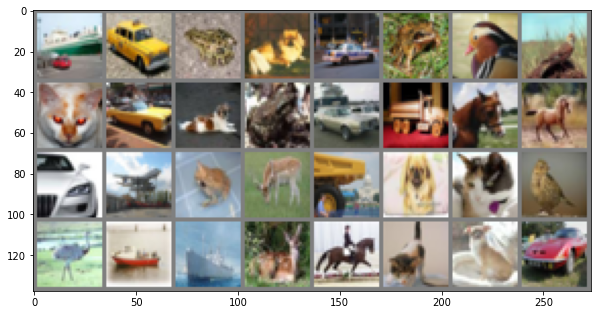

torch.Size([32, 3, 32, 32])


In [4]:
def imshow(img):
    img = .5*img + .5
    plt.figure(figsize=(10,100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.show()

# images, labels = iter(trainloader).next()
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images,nrow=8))
print(images.size()) # 배치 및 이미지 크기 확인

In [5]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [6]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels))

        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(self.out_channels))

    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)

        out = F.relu(x + out)
        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.gap = nn.AvgPool2d(4) # 4: 필터 사이즈
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels
    
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def modeltype(model):
    if model == 'resnet18':
        return ResNet([2, 2, 2, 2])

    elif model == 'resnet34':
        return ResNet([3, 4, 6, 3])



In [8]:
resnet = modeltype('resnet18').to(device)

In [9]:
print(resnet)
PATH = './models/cifar_resnet.pth' # 모델 저장 경로 

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

In [ ]:
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 output node에 별도의 활성화 함수를 사용하지 않아도 된다.
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [ ]:
# 모델의 학습 과정인 4강에서 배운 인공 신경망과 동일하다.
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(trainloader) # 배치 개수

for epoch in range(10):  # 10번 학습을 진행한다.

    running_loss = 0.0
    for data in trainloader:

        inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터 
        
        optimizer.zero_grad()
        outputs = resnet(inputs) # 예측값 산출 
        loss = criterion(outputs, labels) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화

        # print statistics
        running_loss += loss.item()

    loss_.append(running_loss / n)    
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / n))

# AlexNet: 0.207 (epoch 50)
# ResNet: 0.083 (epoch 10)

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
torch.save(resnet.state_dict(), PATH) # 모델 저장

In [12]:
resnet = modeltype('resnet18').to(device)
resnet.load_state_dict(torch.load(PATH)) # 모델 파라메타 불러오기

<All keys matched successfully>

In [13]:
# 평가 데이터를 이용해 정확도를 구해보자.
# output은 미니배치의 결과가 산출되기 때문에 for문을 통해서 test 전체의 예측값을 구한다.

correct = 0
total = 0
with torch.no_grad():
    resnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 개수 누적(총 개수)
        correct += (predicted == labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)
        
print('Test accuracy: %.2f %%' % (100 * correct / total))

# AlexNet: Test accuracy: 76.66 %
# ResNet: Test accuracy: 83.25 %

Test accuracy: 83.25 %
